# 1D nonlinear system with two isolated fixed points

Consider the one-dimensional ODE obtained as the radial component of the Stuart-Landau equation, i.e., $$
\dot{r}=\mu r-r^{3},$$


which can be rescaled to 
$$\dot{R}=R-R^{3}.$$

Page and Kerswell (Page & Kerswell, JFM, 2019) show that local expansion of observables in terms of the Koopman eigenfunctions computed near each fixed point are possible, but the expansions at the two fixed points are not compatible with each other and both diverge at $R=\sqrt{2}/2$.

## Comparing DDL, DMD and EDMD predictions

The following code performs the computations for generating Figure 3. We perform EDMD, DMD and DDL for varying training data and polynomial order for the approximation. 

In [1]:
import distinctipy # can be commented out if distinctipy is not installed
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Setting the colors for plotting

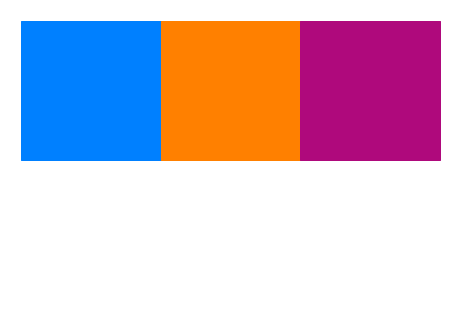

In [2]:
colors = distinctipy.get_colors(3, colorblind_type='Deuteranomaly',exclude_colors = [(1,1,1), (0,0,0)], rng = 6)
distinctipy.color_swatch(colors)

Define the colors (generated by distinctipy https://github.com/alan-turing-institute/distinctipy)

In [3]:
colors = [(0., 0.5, 1.), 
         (1., 0.5, 0.), 
         (0.6847378036821068, 0.034714808407059095, 0.48498819985488384)]

In [4]:
teval2 = np.linspace(0, 10, 100)


In [5]:
from data_driven_linearization.linearization import DataDrivenLinearization
from data_driven_linearization.dmd import dmd
from data_driven_linearization.edmd import edmd



We center the system around the attracting fixed point, $R=1$. We also define helper functions for forward and backward iterating the models.

In [6]:

def ff_attracting(t, x):
    return x + 1 - (x+1)**3

In [7]:
def iterate(x0, A, n):
    iterates = [x0]
    for i in range(n):
        iterates.append(A@iterates[-1])
    return iterates

def iterate_backward(x0, A_inv, n_backward):
    iterates = [x0]
    for i in range(n_backward):
        iterates.append(A_inv@iterates[-1])

    return iterates

## Panel (a), IC = 0.8

We generate a training trajectory starting from IC = 0.8. 

In [45]:
training_ic = 0.8


In [46]:
teval2 = np.linspace(0, 20, 200)
sol_training = solve_ivp(ff_attracting, [0, 40], [training_ic-1], t_eval= teval2, method = 'RK23', rtol = 1e-4)

dt = teval2[1] - teval2[0]

In [47]:
training_data = [sol_training.y]

In [48]:
order_edmd = 5
order_ddl = 5

In [49]:
d = DataDrivenLinearization(1, degree = order_ddl)
d.fit(training_data,  initial_transformation='zero')
d.fit_inverse(training_data)
predicted = d.predict(sol_training.y[:,0], teval2.shape[0]-1)
transformed = d.transform(sol_training.y)

In [50]:
Edmd = edmd(training_data, degree = order_edmd)
nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_training.y.T)


In [51]:
Dmd = dmd(training_data)


In [52]:
ics = [0.9, 0.8, 0.7]


For the DDL predictions we integrate the equivalent continuous system, defined by

$$
\dot{x}=\frac{\log(a)}{\Delta t} x,
$$

if the discrete DDL model was 

$$
x_{n+1} = ax_n,
$$
for sampling time $\Delta t$.

In [53]:
def convert_to_continuous(a_disc, dt):
    return np.log(a_disc) / dt

In [54]:
ddl_vectorfield = lambda t,x : convert_to_continuous(d.linear_model, dt) * x

In [55]:
edmd_inv = np.linalg.inv(Edmd.coef_)


In [56]:
dmd_inv = np.linalg.inv(Dmd.coef_)

In [57]:
import matplotlib

#### Backward integration

Starting from the three initial conditions 
$$
r_0 = 0.9, \quad 0.8, \quad 0.7
$$

we generate both backward and forward trajectories. The models are compared based on how well they capture the forward and backward time behavior. Note that the DMD, EDMD and DDL models are all linear, and will __eventually__ show unbounded growth in backward time. 

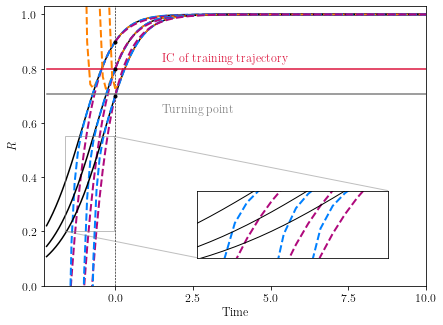

In [58]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12,"font.family": "serif",})
width = 2 * 6.85 / 2
ratio = 8/6
height = width / ratio
fig = plt.figure(figsize =(width, height))
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('$R$')
np.random.seed(3)
backwardtime_min = -2.3
teval_backward = np.arange(0, backwardtime_min, -dt)
label = True
ax.plot([0,0], [0,2], '--', linewidth = 0.6, c='black')

axins = ax.inset_axes([0.4, 0.1, 0.5, 0.24])

errors_ddl_forward = []
errors_ddl_backward = []

errors_dmd_forward = []
errors_dmd_backward = []

errors_edmd_forward = []
errors_edmd_backward = []


for ic in ics:
    sol_backward = solve_ivp(ff_attracting, [0,backwardtime_min], [ic - 1], t_eval= teval_backward)
    sol_forward = solve_ivp(ff_attracting, [0,20], [ic - 1], t_eval= teval2)

    nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_forward.y.T)
    perturb = 0 * (np.random.rand(nonlinear_features.shape[1]) - 0.5)
    transformed_ic = d.transform(sol_forward.y[:,0].reshape(1,-1))
    backwardsol = solve_ivp(ddl_vectorfield, [0, backwardtime_min], transformed_ic[0], t_eval = teval_backward)
    forwardsol = solve_ivp(ddl_vectorfield, [0, 20], transformed_ic[0], t_eval = teval2)
    if label:
        ax.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1.5, c='black', label = 'True trajectory')
    else:
        ax.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1.5, c='black')

    ax.plot(teval2,  1+sol_forward.y[0,:],  '-', linewidth = 1.5, c= 'black')
    
    invtransformed_backward = d.inverse_transform(backwardsol.y.reshape(1,-1))
    invtransformed_forward = d.inverse_transform(forwardsol.y.reshape(1,-1))
    if label:
        ax.plot(teval_backward, 1+invtransformed_backward[0,:], '--', linewidth = 2,c=colors[1], label = 'DDL')
    else:
        ax.plot(teval_backward, 1+invtransformed_backward[0,:], '--',linewidth = 2, c=colors[1])
    ax.plot(teval2, 1+invtransformed_forward[0,:], '--', c=colors[1])
    
    
    errors_ddl_forward.append(np.abs(invtransformed_forward - sol_forward.y))
    errors_ddl_backward.append(np.abs(invtransformed_backward - sol_backward.y))
    
    predicted_edmd_backward = np.array(iterate_backward(nonlinear_features[0,:] ,
                                                        edmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_edmd_forward = np.array(iterate(nonlinear_features[0,:],
                                              Edmd.coef_,
                                              teval2.shape[0]-1))
    
    predicted_dmd_backward = np.array(iterate_backward(sol_forward.y[0,0].reshape(-1,1) ,
                                                        dmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_dmd_forward = np.array(iterate(sol_forward.y[0,0].reshape(-1,1),
                                              Dmd.coef_,
                                              teval2.shape[0]-1))
    
    errors_edmd_forward.append(np.abs(predicted_edmd_forward[:,0] - sol_forward.y))
    errors_edmd_backward.append(np.abs(predicted_edmd_backward[:,0] - sol_backward.y))
    
    errors_dmd_forward.append(np.abs(np.squeeze(predicted_dmd_forward) - sol_forward.y))
    errors_dmd_backward.append(np.abs(np.squeeze(predicted_dmd_backward) - sol_backward.y))
    
    
    if label:
        
        ax.plot(teval2, 1+predicted_edmd_forward[:,0], '--', linewidth = 2, c=colors[0], label = 'EDMD')
    else:
        ax.plot(teval2, 1+predicted_edmd_forward[:,0], '--',linewidth = 2, c=colors[0])
        
        
    if label:
        ax.plot(teval2, 1+predicted_dmd_forward[:,0], '--',linewidth = 2, c=colors[2], label = 'DMD')
    else:
        ax.plot(teval2, 1+predicted_dmd_forward[:,0], '--',linewidth = 2, c=colors[2])

    ax.plot(teval_backward, 1+predicted_dmd_backward[:,0], '--',linewidth = 2, c=colors[2])

    ax.plot(teval_backward, 1+predicted_edmd_backward[:,0], '--',linewidth = 2, c=colors[0])
    label = False
#    ax.plot(0, 1+sol_forward.y[0,0],'.', c='black', markersize = 6)

    #predicted = np.array(iterate(sol2.y[:,0], Dmd.coef_, teval2.shape[0]-1))
ax.plot(teval2,teval2*0 + np.sqrt(2) /2, '-', c='grey')
ax.plot(teval_backward,teval_backward*0 + np.sqrt(2) /2, '-', c='grey')

    
ax.plot(teval2,teval2*0 + training_ic, '-', c='crimson')
ax.plot(teval_backward,teval_backward*0 + training_ic, '-', c='crimson')
    #ax.plot(teval2, 1+predicted[:,0], '--', c=colors[2], label = 'Prediction')
#ax.set_ylim(0.0, 1)
#ax.set_xlim(backwardtime_min, 0.1)
    ## labels:
ax.text(1.5, training_ic + 0.025, "IC of training trajectory", color= 'crimson')
ax.text(1.5, np.sqrt(2)/2 - 0.07, "Turning point", color= 'grey')
ax.set_ylim(0.0, 1.03)

#ax.legend(fontsize = 9, ncols=2)
ax.set_xlim(backwardtime_min, 10)

for ic in ics:
    ax.plot(0, ic, '.', c='black', markersize = 6)
for ic in ics:
    sol_backward = solve_ivp(ff_attracting, [0,backwardtime_min], [ic - 1], t_eval= teval_backward)
    sol_forward = solve_ivp(ff_attracting, [0,20], [ic - 1], t_eval= teval2)

    nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_forward.y.T)
    perturb = 0 * (np.random.rand(nonlinear_features.shape[1]) - 0.5)
    transformed_ic = d.transform(sol_forward.y[:,0].reshape(1,-1))
    backwardsol = solve_ivp(ddl_vectorfield, [0, backwardtime_min], transformed_ic[0], t_eval = teval_backward)
    forwardsol = solve_ivp(ddl_vectorfield, [0, 20], transformed_ic[0], t_eval = teval2)
    axins.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1, c='black')

    axins.plot(teval2,  1+sol_forward.y[0,:],  '-', linewidth = 1, c= 'black')

    invtransformed_backward = d.inverse_transform(backwardsol.y.reshape(1,-1))
    invtransformed_forward = d.inverse_transform(forwardsol.y.reshape(1,-1))

    axins.plot(teval_backward, 1+invtransformed_backward[0,:], '--', linewidth = 2, c=colors[1], label = 'DDL')
    axins.plot(teval2, 1+invtransformed_forward[0,:], '--',  linewidth = 2, c=colors[1])
    predicted_edmd_backward = np.array(iterate_backward(nonlinear_features[0,:] ,
                                                        edmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_edmd_forward = np.array(iterate(nonlinear_features[0,:],
                                              Edmd.coef_,
                                              teval2.shape[0]-1))
    
    predicted_dmd_backward = np.array(iterate_backward(sol_forward.y[0,0].reshape(-1,1) ,
                                                        dmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_dmd_forward = np.array(iterate(sol_forward.y[0,0].reshape(-1,1),
                                              Dmd.coef_,
                                              teval2.shape[0]-1))
    
    axins.plot(teval2, 1+predicted_edmd_forward[:,0], '--',  linewidth = 2, c=colors[0], label = 'EDMD')
    axins.plot(teval2, 1+predicted_dmd_forward[:,0], '--',  linewidth = 2, c=colors[2], label = 'DMD')
    axins.plot(teval_backward, 1+predicted_dmd_backward[:,0], '--', linewidth = 2,  c=colors[2])

    axins.plot(teval_backward, 1+predicted_edmd_backward[:,0], '--', linewidth = 2,  c=colors[0])
    axins.plot(0, 1+sol_forward.y[0,0],'.', c='black', markersize = 6)

axins.plot(teval_backward, teval_backward*0 + training_ic, '-', linewidth = 2, c='crimson')

#axins.set_ylim(0.89, 1.001)
#axins.set_xlim(0.1, 1.5)
axins.set_ylim(0.2, 0.55)
axins.set_xlim(-1.62, -0.05)


axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins)
ax.set_xticks([0., 2.5, 5., 7.5, 10.])
#plt.savefig('../figures_paper/fig_1dim_ddl_%s_%s.pdf' %(order_ddl, training_ic), bbox_inches='tight')

### Panel (b): IC = 0.4

In [59]:
training_ic = 0.4


In [60]:
teval2 = np.linspace(0, 20, 200)
sol_training = solve_ivp(ff_attracting, [0, 40], [training_ic-1], t_eval= teval2, method = 'RK23', rtol = 1e-4)

dt = teval2[1] - teval2[0]

In [61]:
training_data = [sol_training.y]

In [62]:
order_edmd = 5
order_ddl = 5

In [63]:
d = DataDrivenLinearization(1, degree = order_ddl)
d.fit(training_data,  initial_transformation='zero')
d.fit_inverse(training_data)
predicted = d.predict(sol_training.y[:,0], teval2.shape[0]-1)
transformed = d.transform(sol_training.y)

In [64]:
Edmd = edmd(training_data, degree = order_edmd)
nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_training.y.T)


In [65]:
Dmd = dmd(training_data)


In [66]:
ddl_vectorfield = lambda t,x : convert_to_continuous(d.linear_model, dt) * x

In [67]:
edmd_inv = np.linalg.inv(Edmd.coef_)


In [68]:
dmd_inv = np.linalg.inv(Dmd.coef_)

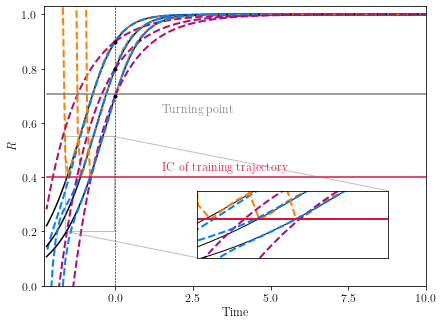

In [69]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12,"font.family": "serif",})
width = 2 * 6.85 / 2
ratio = 8/6
height = width / ratio
fig = plt.figure(figsize =(width, height))
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('$R$')
np.random.seed(3)
backwardtime_min = -2.3
teval_backward = np.arange(0, backwardtime_min, -dt)
label = True
ax.plot([0,0], [0,2], '--', linewidth = 0.6, c='black')

axins = ax.inset_axes([0.4, 0.1, 0.5, 0.24])

errors_ddl_forward = []
errors_ddl_backward = []

errors_dmd_forward = []
errors_dmd_backward = []

errors_edmd_forward = []
errors_edmd_backward = []


for ic in ics:
    sol_backward = solve_ivp(ff_attracting, [0,backwardtime_min], [ic - 1], t_eval= teval_backward)
    sol_forward = solve_ivp(ff_attracting, [0,20], [ic - 1], t_eval= teval2)

    nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_forward.y.T)
    perturb = 0 * (np.random.rand(nonlinear_features.shape[1]) - 0.5)
    transformed_ic = d.transform(sol_forward.y[:,0].reshape(1,-1))
    backwardsol = solve_ivp(ddl_vectorfield, [0, backwardtime_min], transformed_ic[0], t_eval = teval_backward)
    forwardsol = solve_ivp(ddl_vectorfield, [0, 20], transformed_ic[0], t_eval = teval2)
    if label:
        ax.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1.5, c='black', label = 'True trajectory')
    else:
        ax.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1.5, c='black')

    ax.plot(teval2,  1+sol_forward.y[0,:],  '-', linewidth = 1.5, c= 'black')
    
    invtransformed_backward = d.inverse_transform(backwardsol.y.reshape(1,-1))
    invtransformed_forward = d.inverse_transform(forwardsol.y.reshape(1,-1))
    if label:
        ax.plot(teval_backward, 1+invtransformed_backward[0,:], '--', linewidth = 2,c=colors[1], label = 'DDL')
    else:
        ax.plot(teval_backward, 1+invtransformed_backward[0,:], '--',linewidth = 2, c=colors[1])
    ax.plot(teval2, 1+invtransformed_forward[0,:], '--', c=colors[1])
    
    
    errors_ddl_forward.append(np.abs(invtransformed_forward - sol_forward.y))
    errors_ddl_backward.append(np.abs(invtransformed_backward - sol_backward.y))
    
    predicted_edmd_backward = np.array(iterate_backward(nonlinear_features[0,:] ,
                                                        edmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_edmd_forward = np.array(iterate(nonlinear_features[0,:],
                                              Edmd.coef_,
                                              teval2.shape[0]-1))
    
    predicted_dmd_backward = np.array(iterate_backward(sol_forward.y[0,0].reshape(-1,1) ,
                                                        dmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_dmd_forward = np.array(iterate(sol_forward.y[0,0].reshape(-1,1),
                                              Dmd.coef_,
                                              teval2.shape[0]-1))
    
    errors_edmd_forward.append(np.abs(predicted_edmd_forward[:,0] - sol_forward.y))
    errors_edmd_backward.append(np.abs(predicted_edmd_backward[:,0] - sol_backward.y))
    
    errors_dmd_forward.append(np.abs(np.squeeze(predicted_dmd_forward) - sol_forward.y))
    errors_dmd_backward.append(np.abs(np.squeeze(predicted_dmd_backward) - sol_backward.y))
    
    
    if label:
        
        ax.plot(teval2, 1+predicted_edmd_forward[:,0], '--', linewidth = 2, c=colors[0], label = 'EDMD')
    else:
        ax.plot(teval2, 1+predicted_edmd_forward[:,0], '--',linewidth = 2, c=colors[0])
        
        
    if label:
        ax.plot(teval2, 1+predicted_dmd_forward[:,0], '--',linewidth = 2, c=colors[2], label = 'DMD')
    else:
        ax.plot(teval2, 1+predicted_dmd_forward[:,0], '--',linewidth = 2, c=colors[2])

    ax.plot(teval_backward, 1+predicted_dmd_backward[:,0], '--',linewidth = 2, c=colors[2])

    ax.plot(teval_backward, 1+predicted_edmd_backward[:,0], '--',linewidth = 2, c=colors[0])
    label = False
#    ax.plot(0, 1+sol_forward.y[0,0],'.', c='black', markersize = 6)

    #predicted = np.array(iterate(sol2.y[:,0], Dmd.coef_, teval2.shape[0]-1))
ax.plot(teval2,teval2*0 + np.sqrt(2) /2, '-', c='grey')
ax.plot(teval_backward,teval_backward*0 + np.sqrt(2) /2, '-', c='grey')

    
ax.plot(teval2,teval2*0 + training_ic, '-', c='crimson')
ax.plot(teval_backward,teval_backward*0 + training_ic, '-', c='crimson')
    #ax.plot(teval2, 1+predicted[:,0], '--', c=colors[2], label = 'Prediction')
#ax.set_ylim(0.0, 1)
#ax.set_xlim(backwardtime_min, 0.1)
    ## labels:
ax.text(1.5, training_ic + 0.025, "IC of training trajectory", color= 'crimson')
ax.text(1.5, np.sqrt(2)/2 - 0.07, "Turning point", color= 'grey')
ax.set_ylim(0.0, 1.03)

#ax.legend(fontsize = 9, ncols=2)
ax.set_xlim(backwardtime_min, 10)

for ic in ics:
    ax.plot(0, ic, '.', c='black', markersize = 6)
for ic in ics:
    sol_backward = solve_ivp(ff_attracting, [0,backwardtime_min], [ic - 1], t_eval= teval_backward)
    sol_forward = solve_ivp(ff_attracting, [0,20], [ic - 1], t_eval= teval2)

    nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_forward.y.T)
    perturb = 0 * (np.random.rand(nonlinear_features.shape[1]) - 0.5)
    transformed_ic = d.transform(sol_forward.y[:,0].reshape(1,-1))
    backwardsol = solve_ivp(ddl_vectorfield, [0, backwardtime_min], transformed_ic[0], t_eval = teval_backward)
    forwardsol = solve_ivp(ddl_vectorfield, [0, 20], transformed_ic[0], t_eval = teval2)
    axins.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1, c='black')

    axins.plot(teval2,  1+sol_forward.y[0,:],  '-', linewidth = 1, c= 'black')

    invtransformed_backward = d.inverse_transform(backwardsol.y.reshape(1,-1))
    invtransformed_forward = d.inverse_transform(forwardsol.y.reshape(1,-1))

    axins.plot(teval_backward, 1+invtransformed_backward[0,:], '--', linewidth = 2, c=colors[1], label = 'DDL')
    axins.plot(teval2, 1+invtransformed_forward[0,:], '--',  linewidth = 2, c=colors[1])
    predicted_edmd_backward = np.array(iterate_backward(nonlinear_features[0,:] ,
                                                        edmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_edmd_forward = np.array(iterate(nonlinear_features[0,:],
                                              Edmd.coef_,
                                              teval2.shape[0]-1))
    
    predicted_dmd_backward = np.array(iterate_backward(sol_forward.y[0,0].reshape(-1,1) ,
                                                        dmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_dmd_forward = np.array(iterate(sol_forward.y[0,0].reshape(-1,1),
                                              Dmd.coef_,
                                              teval2.shape[0]-1))
    
    axins.plot(teval2, 1+predicted_edmd_forward[:,0], '--',  linewidth = 2, c=colors[0], label = 'EDMD')
    axins.plot(teval2, 1+predicted_dmd_forward[:,0], '--',  linewidth = 2, c=colors[2], label = 'DMD')
    axins.plot(teval_backward, 1+predicted_dmd_backward[:,0], '--', linewidth = 2,  c=colors[2])

    axins.plot(teval_backward, 1+predicted_edmd_backward[:,0], '--', linewidth = 2,  c=colors[0])
    axins.plot(0, 1+sol_forward.y[0,0],'.', c='black', markersize = 6)

axins.plot(teval_backward, teval_backward*0 + training_ic, '-', linewidth = 2, c='crimson')

#axins.set_ylim(0.89, 1.001)
#axins.set_xlim(0.1, 1.5)
axins.set_ylim(0.2, 0.55)
axins.set_xlim(-1.62, -0.05)


axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins)
ax.set_xticks([0., 2.5, 5., 7.5, 10.])
#plt.savefig('../figures_paper/fig_1dim_ddl_%s_%s.pdf' %(order_ddl, training_ic), bbox_inches='tight')

### Panel (c): IC = 0.1, order = 10

In [70]:
training_ic = 0.1


In [71]:
teval2 = np.linspace(0, 20, 200)
sol_training = solve_ivp(ff_attracting, [0, 40], [training_ic-1], t_eval= teval2, method = 'RK23', rtol = 1e-4)

dt = teval2[1] - teval2[0]

In [72]:
training_data = [sol_training.y]

In [73]:
order_edmd = 10
order_ddl = 10

In [74]:
d = DataDrivenLinearization(1, degree = order_ddl)
d.fit(training_data,  initial_transformation='zero')
d.fit_inverse(training_data)
predicted = d.predict(sol_training.y[:,0], teval2.shape[0]-1)
transformed = d.transform(sol_training.y)

In [75]:
Edmd = edmd(training_data, degree = order_edmd)
nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_training.y.T)


In [76]:
Dmd = dmd(training_data)


In [77]:
edmd_inv = np.linalg.inv(Edmd.coef_)


In [78]:
dmd_inv = np.linalg.inv(Dmd.coef_)

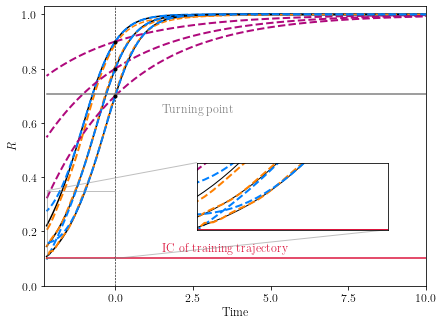

In [88]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12,"font.family": "serif",})
width = 2 * 6.85 / 2
ratio = 8/6
height = width / ratio
fig = plt.figure(figsize =(width, height))
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('$R$')
np.random.seed(3)
backwardtime_min = -2.3
teval_backward = np.arange(0, backwardtime_min, -dt)
label = True
ax.plot([0,0], [0,2], '--', linewidth = 0.6, c='black')

axins = ax.inset_axes([0.4, 0.2, 0.5, 0.24])

errors_ddl_forward = []
errors_ddl_backward = []

errors_dmd_forward = []
errors_dmd_backward = []

errors_edmd_forward = []
errors_edmd_backward = []


for ic in ics:
    sol_backward = solve_ivp(ff_attracting, [0,backwardtime_min], [ic - 1], t_eval= teval_backward)
    sol_forward = solve_ivp(ff_attracting, [0,20], [ic - 1], t_eval= teval2)

    nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_forward.y.T)
    perturb = 0 * (np.random.rand(nonlinear_features.shape[1]) - 0.5)
    transformed_ic = d.transform(sol_forward.y[:,0].reshape(1,-1))
    backwardsol = solve_ivp(ddl_vectorfield, [0, backwardtime_min], transformed_ic[0], t_eval = teval_backward)
    forwardsol = solve_ivp(ddl_vectorfield, [0, 20], transformed_ic[0], t_eval = teval2)
    if label:
        ax.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1.5, c='black', label = 'True trajectory')
    else:
        ax.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1.5, c='black')

    ax.plot(teval2,  1+sol_forward.y[0,:],  '-', linewidth = 1.5, c= 'black')
    
    invtransformed_backward = d.inverse_transform(backwardsol.y.reshape(1,-1))
    invtransformed_forward = d.inverse_transform(forwardsol.y.reshape(1,-1))
    if label:
        ax.plot(teval_backward, 1+invtransformed_backward[0,:], '--', linewidth = 2,c=colors[1], label = 'DDL')
    else:
        ax.plot(teval_backward, 1+invtransformed_backward[0,:], '--',linewidth = 2, c=colors[1])
    ax.plot(teval2, 1+invtransformed_forward[0,:], '--', c=colors[1])
    
    
    errors_ddl_forward.append(np.abs(invtransformed_forward - sol_forward.y))
    errors_ddl_backward.append(np.abs(invtransformed_backward - sol_backward.y))
    
    predicted_edmd_backward = np.array(iterate_backward(nonlinear_features[0,:] ,
                                                        edmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_edmd_forward = np.array(iterate(nonlinear_features[0,:],
                                              Edmd.coef_,
                                              teval2.shape[0]-1))
    
    predicted_dmd_backward = np.array(iterate_backward(sol_forward.y[0,0].reshape(-1,1) ,
                                                        dmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_dmd_forward = np.array(iterate(sol_forward.y[0,0].reshape(-1,1),
                                              Dmd.coef_,
                                              teval2.shape[0]-1))
    
    errors_edmd_forward.append(np.abs(predicted_edmd_forward[:,0] - sol_forward.y))
    errors_edmd_backward.append(np.abs(predicted_edmd_backward[:,0] - sol_backward.y))
    
    errors_dmd_forward.append(np.abs(np.squeeze(predicted_dmd_forward) - sol_forward.y))
    errors_dmd_backward.append(np.abs(np.squeeze(predicted_dmd_backward) - sol_backward.y))
    
    
    if label:
        
        ax.plot(teval2, 1+predicted_edmd_forward[:,0], '--', linewidth = 2, c=colors[0], label = 'EDMD')
    else:
        ax.plot(teval2, 1+predicted_edmd_forward[:,0], '--',linewidth = 2, c=colors[0])
        
        
    if label:
        ax.plot(teval2, 1+predicted_dmd_forward[:,0], '--',linewidth = 2, c=colors[2], label = 'DMD')
    else:
        ax.plot(teval2, 1+predicted_dmd_forward[:,0], '--',linewidth = 2, c=colors[2])

    ax.plot(teval_backward, 1+predicted_dmd_backward[:,0], '--',linewidth = 2, c=colors[2])

    ax.plot(teval_backward, 1+predicted_edmd_backward[:,0], '--',linewidth = 2, c=colors[0])
    label = False
#    ax.plot(0, 1+sol_forward.y[0,0],'.', c='black', markersize = 6)

    #predicted = np.array(iterate(sol2.y[:,0], Dmd.coef_, teval2.shape[0]-1))
ax.plot(teval2,teval2*0 + np.sqrt(2) /2, '-', c='grey')
ax.plot(teval_backward,teval_backward*0 + np.sqrt(2) /2, '-', c='grey')

    
ax.plot(teval2,teval2*0 + training_ic, '-', c='crimson')
ax.plot(teval_backward,teval_backward*0 + training_ic, '-', c='crimson')
    #ax.plot(teval2, 1+predicted[:,0], '--', c=colors[2], label = 'Prediction')
#ax.set_ylim(0.0, 1)
#ax.set_xlim(backwardtime_min, 0.1)
    ## labels:
ax.text(1.5, training_ic + 0.025, "IC of training trajectory", color= 'crimson')
ax.text(1.5, np.sqrt(2)/2 - 0.07, "Turning point", color= 'grey')
ax.set_ylim(0.0, 1.03)

#ax.legend(fontsize = 9, ncols=2)
ax.set_xlim(backwardtime_min, 10)

for ic in ics:
    ax.plot(0, ic, '.', c='black', markersize = 6)
for ic in ics:
    sol_backward = solve_ivp(ff_attracting, [0,backwardtime_min], [ic - 1], t_eval= teval_backward)
    sol_forward = solve_ivp(ff_attracting, [0,20], [ic - 1], t_eval= teval2)

    nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_forward.y.T)
    perturb = 0 * (np.random.rand(nonlinear_features.shape[1]) - 0.5)
    transformed_ic = d.transform(sol_forward.y[:,0].reshape(1,-1))
    backwardsol = solve_ivp(ddl_vectorfield, [0, backwardtime_min], transformed_ic[0], t_eval = teval_backward)
    forwardsol = solve_ivp(ddl_vectorfield, [0, 20], transformed_ic[0], t_eval = teval2)
    axins.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1, c='black')

    axins.plot(teval2,  1+sol_forward.y[0,:],  '-', linewidth = 1, c= 'black')

    invtransformed_backward = d.inverse_transform(backwardsol.y.reshape(1,-1))
    invtransformed_forward = d.inverse_transform(forwardsol.y.reshape(1,-1))|

    axins.plot(teval_backward, 1+invtransformed_backward[0,:], '--', linewidth = 2, c=colors[1], label = 'DDL')
    axins.plot(teval2, 1+invtransformed_forward[0,:], '--',  linewidth = 2, c=colors[1])
    predicted_edmd_backward = np.array(iterate_backward(nonlinear_features[0,:] ,
                                                        edmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_edmd_forward = np.array(iterate(nonlinear_features[0,:],
                                              Edmd.coef_,
                                              teval2.shape[0]-1))
    
    predicted_dmd_backward = np.array(iterate_backward(sol_forward.y[0,0].reshape(-1,1) ,
                                                        dmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_dmd_forward = np.array(iterate(sol_forward.y[0,0].reshape(-1,1),
                                              Dmd.coef_,
                                              teval2.shape[0]-1))
    
    axins.plot(teval2, 1+predicted_edmd_forward[:,0], '--',  linewidth = 2, c=colors[0], label = 'EDMD')
    axins.plot(teval2, 1+predicted_dmd_forward[:,0], '--',  linewidth = 2, c=colors[2], label = 'DMD')
    axins.plot(teval_backward, 1+predicted_dmd_backward[:,0], '--', linewidth = 2,  c=colors[2])

    axins.plot(teval_backward, 1+predicted_edmd_backward[:,0], '--', linewidth = 2,  c=colors[0])
    axins.plot(0, 1+sol_forward.y[0,0],'.', c='black', markersize = 6)

axins.plot(teval_backward, teval_backward*0 + training_ic, '-', linewidth = 2, c='crimson')

#axins.set_ylim(0.89, 1.001)
#axins.set_xlim(0.1, 1.5)
axins.set_ylim(0.1, 0.35)
axins.set_xlim(-2.2, -0.01)


axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins)
ax.set_xticks([0., 2.5, 5., 7.5, 10.])
#plt.savefig('../figures_paper/fig_1dim_ddl_%s_%s.pdf' %(order_ddl, training_ic), bbox_inches='tight')

### Panel (d): IC = 0.1, order = 18

In [79]:
training_ic = 0.1


In [80]:
teval2 = np.linspace(0, 20, 205)
sol_training = solve_ivp(ff_attracting, [0, 40], [training_ic-1], t_eval= teval2, method = 'RK23', rtol = 1e-4)

dt = teval2[1] - teval2[0]

In [81]:
training_data = [sol_training.y]

In [82]:
order_edmd = 18
order_ddl = 18

In [83]:
d = DataDrivenLinearization(1, degree = order_ddl)
d.fit(training_data,  initial_transformation='zero', verbose=True)
d.fit_inverse(training_data)
predicted = d.predict(sol_training.y[:,0], teval2.shape[0]-1)
transformed = d.transform(sol_training.y)

Initial cost:  1.006720330369964
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.2739543596243068e-05
        x: [ 8.955e-01  7.010e+00 ... -2.804e+00 -6.051e+01]
      nit: 219
      jac: [-8.419e-08 -1.689e-09 ...  2.321e-10 -1.013e-09]
 hess_inv: [[ 1.401e+01 -4.123e+01 ... -1.996e+03  2.843e+04]
            [-4.123e+01  1.835e+05 ... -3.628e+05 -1.044e+06]
            ...
            [-1.996e+03 -3.628e+05 ...  1.140e+06 -1.277e+06]
            [ 2.843e+04 -1.044e+06 ... -1.277e+06  8.164e+07]]
     nfev: 234
     njev: 234
Final cost:  1.2739543596243068e-05


In [84]:
Edmd = edmd(training_data, degree = order_edmd)
nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_training.y.T)


In [85]:
Dmd = dmd(training_data)


In [86]:
edmd_inv = np.linalg.inv(Edmd.coef_)


In [87]:
dmd_inv = np.linalg.inv(Dmd.coef_)

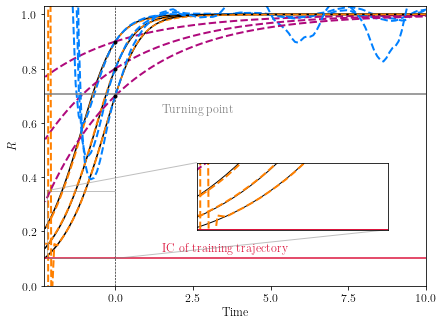

In [88]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12,"font.family": "serif",})
width = 2 * 6.85 / 2
ratio = 8/6
height = width / ratio
fig = plt.figure(figsize =(width, height))
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('$R$')
np.random.seed(3)
backwardtime_min = -2.3
teval_backward = np.arange(0, backwardtime_min, -dt)
label = True
ax.plot([0,0], [0,2], '--', linewidth = 0.6, c='black')

axins = ax.inset_axes([0.4, 0.2, 0.5, 0.24])

errors_ddl_forward = []
errors_ddl_backward = []

errors_dmd_forward = []
errors_dmd_backward = []

errors_edmd_forward = []
errors_edmd_backward = []


for ic in ics:
    sol_backward = solve_ivp(ff_attracting, [0,backwardtime_min], [ic - 1], t_eval= teval_backward)
    sol_forward = solve_ivp(ff_attracting, [0,20], [ic - 1], t_eval= teval2)

    nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_forward.y.T)
    perturb = 0 * (np.random.rand(nonlinear_features.shape[1]) - 0.5)
    transformed_ic = d.transform(sol_forward.y[:,0].reshape(1,-1))
    backwardsol = solve_ivp(ddl_vectorfield, [0, backwardtime_min], transformed_ic[0], t_eval = teval_backward)
    forwardsol = solve_ivp(ddl_vectorfield, [0, 20], transformed_ic[0], t_eval = teval2)
    if label:
        ax.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1.5, c='black', label = 'True trajectory')
    else:
        ax.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1.5, c='black')

    ax.plot(teval2,  1+sol_forward.y[0,:],  '-', linewidth = 1.5, c= 'black')
    
    invtransformed_backward = d.inverse_transform(backwardsol.y.reshape(1,-1))
    invtransformed_forward = d.inverse_transform(forwardsol.y.reshape(1,-1))
    if label:
        ax.plot(teval_backward, 1+invtransformed_backward[0,:], '--', linewidth = 2,c=colors[1], label = 'DDL')
    else:
        ax.plot(teval_backward, 1+invtransformed_backward[0,:], '--',linewidth = 2, c=colors[1])
    ax.plot(teval2, 1+invtransformed_forward[0,:], '--', c=colors[1])
    
    
    errors_ddl_forward.append(np.abs(invtransformed_forward - sol_forward.y))
    errors_ddl_backward.append(np.abs(invtransformed_backward - sol_backward.y))
    
    predicted_edmd_backward = np.array(iterate_backward(nonlinear_features[0,:] ,
                                                        edmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_edmd_forward = np.array(iterate(nonlinear_features[0,:],
                                              Edmd.coef_,
                                              teval2.shape[0]-1))
    
    predicted_dmd_backward = np.array(iterate_backward(sol_forward.y[0,0].reshape(-1,1) ,
                                                        dmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_dmd_forward = np.array(iterate(sol_forward.y[0,0].reshape(-1,1),
                                              Dmd.coef_,
                                              teval2.shape[0]-1))
    
    errors_edmd_forward.append(np.abs(predicted_edmd_forward[:,0] - sol_forward.y))
    errors_edmd_backward.append(np.abs(predicted_edmd_backward[:,0] - sol_backward.y))
    
    errors_dmd_forward.append(np.abs(np.squeeze(predicted_dmd_forward) - sol_forward.y))
    errors_dmd_backward.append(np.abs(np.squeeze(predicted_dmd_backward) - sol_backward.y))
    
    
    if label:
        
        ax.plot(teval2, 1+predicted_edmd_forward[:,0], '--', linewidth = 2, c=colors[0], label = 'EDMD')
    else:
        ax.plot(teval2, 1+predicted_edmd_forward[:,0], '--',linewidth = 2, c=colors[0])
        
        
    if label:
        ax.plot(teval2, 1+predicted_dmd_forward[:,0], '--',linewidth = 2, c=colors[2], label = 'DMD')
    else:
        ax.plot(teval2, 1+predicted_dmd_forward[:,0], '--',linewidth = 2, c=colors[2])

    ax.plot(teval_backward, 1+predicted_dmd_backward[:,0], '--',linewidth = 2, c=colors[2])

    ax.plot(teval_backward, 1+predicted_edmd_backward[:,0], '--',linewidth = 2, c=colors[0])
    label = False
#    ax.plot(0, 1+sol_forward.y[0,0],'.', c='black', markersize = 6)

    #predicted = np.array(iterate(sol2.y[:,0], Dmd.coef_, teval2.shape[0]-1))
ax.plot(teval2,teval2*0 + np.sqrt(2) /2, '-', c='grey')
ax.plot(teval_backward,teval_backward*0 + np.sqrt(2) /2, '-', c='grey')

    
ax.plot(teval2,teval2*0 + training_ic, '-', c='crimson')
ax.plot(teval_backward,teval_backward*0 + training_ic, '-', c='crimson')
    #ax.plot(teval2, 1+predicted[:,0], '--', c=colors[2], label = 'Prediction')
#ax.set_ylim(0.0, 1)
#ax.set_xlim(backwardtime_min, 0.1)
    ## labels:
ax.text(1.5, training_ic + 0.025, "IC of training trajectory", color= 'crimson')
ax.text(1.5, np.sqrt(2)/2 - 0.07, "Turning point", color= 'grey')
ax.set_ylim(0.0, 1.03)

#ax.legend(fontsize = 9, ncols=2)
ax.set_xlim(backwardtime_min, 10)

for ic in ics:
    ax.plot(0, ic, '.', c='black', markersize = 6)
for ic in ics:
    sol_backward = solve_ivp(ff_attracting, [0,backwardtime_min], [ic - 1], t_eval= teval_backward)
    sol_forward = solve_ivp(ff_attracting, [0,20], [ic - 1], t_eval= teval2)

    nonlinear_features = PolynomialFeatures(degree = order_edmd, include_bias=False).fit_transform(sol_forward.y.T)
    perturb = 0 * (np.random.rand(nonlinear_features.shape[1]) - 0.5)
    transformed_ic = d.transform(sol_forward.y[:,0].reshape(1,-1))
    backwardsol = solve_ivp(ddl_vectorfield, [0, backwardtime_min], transformed_ic[0], t_eval = teval_backward)
    forwardsol = solve_ivp(ddl_vectorfield, [0, 20], transformed_ic[0], t_eval = teval2)
    axins.plot(teval_backward,  1+sol_backward.y[0,:],  '-', linewidth = 1, c='black')

    axins.plot(teval2,  1+sol_forward.y[0,:],  '-', linewidth = 1, c= 'black')

    invtransformed_backward = d.inverse_transform(backwardsol.y.reshape(1,-1))
    invtransformed_forward = d.inverse_transform(forwardsol.y.reshape(1,-1))

    axins.plot(teval_backward, 1+invtransformed_backward[0,:], '--', linewidth = 2, c=colors[1], label = 'DDL')
    axins.plot(teval2, 1+invtransformed_forward[0,:], '--',  linewidth = 2, c=colors[1])
    predicted_edmd_backward = np.array(iterate_backward(nonlinear_features[0,:] ,
                                                        edmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_edmd_forward = np.array(iterate(nonlinear_features[0,:],
                                              Edmd.coef_,
                                              teval2.shape[0]-1))
    
    predicted_dmd_backward = np.array(iterate_backward(sol_forward.y[0,0].reshape(-1,1) ,
                                                        dmd_inv, 
                                                        teval_backward.shape[0]-1 ))
    predicted_dmd_forward = np.array(iterate(sol_forward.y[0,0].reshape(-1,1),
                                              Dmd.coef_,
                                              teval2.shape[0]-1))
    
    axins.plot(teval2, 1+predicted_edmd_forward[:,0], '--',  linewidth = 2, c=colors[0], label = 'EDMD')
    axins.plot(teval2, 1+predicted_dmd_forward[:,0], '--',  linewidth = 2, c=colors[2], label = 'DMD')
    axins.plot(teval_backward, 1+predicted_dmd_backward[:,0], '--', linewidth = 2,  c=colors[2])

    axins.plot(teval_backward, 1+predicted_edmd_backward[:,0], '--', linewidth = 2,  c=colors[0])
    axins.plot(0, 1+sol_forward.y[0,0],'.', c='black', markersize = 6)

axins.plot(teval_backward, teval_backward*0 + training_ic, '-', linewidth = 2, c='crimson')

#axins.set_ylim(0.89, 1.001)
#axins.set_xlim(0.1, 1.5)
axins.set_ylim(0.1, 0.35)
axins.set_xlim(-2.2, -0.01)


axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins)
ax.set_xticks([0., 2.5, 5., 7.5, 10.])
#plt.savefig('../figures_paper/fig_1dim_ddl_%s_%s.pdf' %(order_ddl, training_ic), bbox_inches='tight')